# Ensemble Batch PI's

### Loading Libraries

In [1]:
# Numerical Computing
import numpy as np

# Data Manipulation
import pandas as pd

# Warnings
import warnings
warnings.filterwarnings('ignore')

#Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib.ticker import FormatStrFormatter
from yellowbrick.regressor import PredictionError
from matplotlib.offsetbox import AnnotationBbox, TextArea

# SciPy
from scipy.stats import rankdata
from scipy.stats import randint, uniform

#
import openml

# Notebook Opt
from tqdm import tqdm

# Crepes
from crepes import WrapRegressor
from crepes.extras import binning
from crepes.extras import DifficultyEstimator

# Mapie
from mapie.subsample import Subsample
from mapie.regression import MapieQuantileRegressor, MapieRegressor
from mapie.metrics import regression_coverage_score, regression_mean_width_score

# Scikit-Learn
from sklearn.svm import SVC, LinearSVC
from sklearn.datasets import fetch_openml
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize, LabelEncoder
from sklearn.preprocessing import label_binarize, OrdinalEncoder
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import log_loss, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor,AdaBoostClassifier, HistGradientBoostingRegressor

# Boosting Libraries
from lightgbm import LGBMRegressor
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Conformal Libraries
from nonconformist.nc import NcFactory
from nonconformist.cp import IcpClassifier
from nonconformist.cp import TcpClassifier
from nonconformist.base import ClassifierAdapter
from nonconformist.nc import InverseProbabilityErrFunc, MarginErrFunc, ClassifierNc

### Fetching Data

In [3]:
from sklearn.datasets import fetch_openml

In [5]:
bike_sharing = fetch_openml(
    name="Bike_Sharing_Demand", version=2, data_home=None, return_X_y=False
)
df = bike_sharing.frame

In [7]:
# First 5 rows
df.head()

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed,count
0,spring,0.0,1.0,0.0,False,6.0,False,clear,9.84,14.395,0.81,0.0,16.0
1,spring,0.0,1.0,1.0,False,6.0,False,clear,9.02,13.635,0.80,0.0,40.0
2,spring,0.0,1.0,2.0,False,6.0,False,clear,9.02,13.635,0.80,0.0,32.0
3,spring,0.0,1.0,3.0,False,6.0,False,clear,9.84,14.395,0.75,0.0,13.0
4,spring,0.0,1.0,4.0,False,6.0,False,clear,9.84,14.395,0.75,0.0,1.0


In [9]:
df.shape

(17379, 13)

In [11]:
df.groupby(["weekday", "hour"])["count"].mean()

weekday  hour
0.0      0.0      93.990385
         1.0      77.432692
         2.0      61.627451
         3.0      31.144231
         4.0       9.362745
                    ...    
6.0      19.0    239.932692
         20.0    180.865385
         21.0    156.000000
         22.0    139.663462
         23.0    115.855769
Name: count, Length: 168, dtype: float64

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

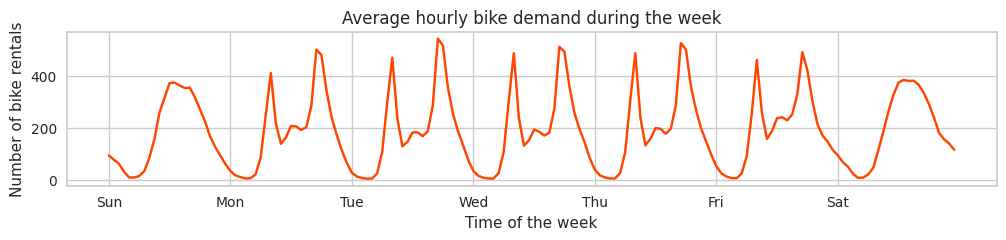

In [13]:
fig, ax = plt.subplots(figsize=(12, 2))

average_week_demand = df.groupby(["weekday", "hour"])["count"].mean()

average_week_demand.plot(ax=ax, color="#FF4500") 

_ = ax.set(
    title="Average hourly bike demand during the week",
    xticks=[i * 24 for i in range(7)],
    xticklabels=["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"],
    xlabel="Time of the week",
    ylabel="Number of bike rentals",
)

In [15]:
df = df.sample(500)

y = df["count"] / df["count"].max()
X = df.drop("count", axis="columns")

X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)
y_train, y_test = train_test_split(y, test_size=0.2, shuffle=False)
     

In [17]:
y.shape

(500,)

## Data Bootstrapping

In [19]:
class DataFrameBootstrapper:
    def __init__(self, n_samples: int):
        self.n_samples = n_samples

    def __call__(
        self, X: np.ndarray, y: np.ndarray
    ) -> tuple[np.ndarray, list[tuple[np.ndarray, np.ndarray]]]:
        indices = np.random.choice(y.shape[0], size=(self.n_samples, y.shape[0]))
        return indices, [(X.iloc[idx], y.iloc[idx]) for idx in indices]

In [21]:
n_bs_samples = 10

bs_indices, bs_train_data = DataFrameBootstrapper(n_samples=n_bs_samples)(
    X_train, y_train
)

In [23]:
# Returns 10 boostrap samples from the training set
bs_indices.shape

(10, 400)

In [27]:
bs_indices

array([[213, 258,  14, ..., 213, 205, 190],
       [ 22,  15, 113, ..., 100, 165, 397],
       [ 10, 301, 362, ..., 345,  80, 286],
       ...,
       [278, 305, 226, ...,  80, 103, 280],
       [103,  39, 369, ..., 114, 195, 301],
       [206,  91,  87, ..., 228, 253, 168]])

In [29]:
X_train.shape

(400, 12)

In [31]:
len(bs_train_data)

10

In [33]:
# First Bootstrap Sample - X
bs_train_data[0][0]

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed
295,spring,0.0,1.0,18.0,False,4.0,True,clear,8.20,9.090,0.40,22.0028
15006,fall,1.0,9.0,11.0,False,6.0,False,clear,28.70,32.575,0.58,19.0012
2855,summer,0.0,5.0,21.0,False,2.0,True,misty,26.24,31.060,0.61,30.0026
17205,spring,1.0,12.0,17.0,False,1.0,True,rain,9.84,12.120,0.93,11.0014
11178,summer,1.0,4.0,23.0,False,0.0,False,clear,27.06,31.060,0.50,26.0027
...,...,...,...,...,...,...,...,...,...,...,...,...
14325,fall,1.0,8.0,2.0,False,6.0,False,misty,27.06,31.060,0.74,6.0032
12639,summer,1.0,6.0,20.0,False,5.0,True,clear,27.88,31.820,0.44,12.9980
295,spring,0.0,1.0,18.0,False,4.0,True,clear,8.20,9.090,0.40,22.0028
17009,winter,1.0,12.0,12.0,False,0.0,False,misty,15.58,19.695,0.82,12.9980


In [35]:
# First Bootstrap Sample - y
bs_train_data[0][1]

295      0.159116
15006    0.691713
2855     0.248619
17205    0.028729
11178    0.099448
           ...   
14325    0.087293
12639    0.425414
295      0.159116
17009    0.460773
16683    0.106077
Name: count, Length: 400, dtype: float64

In [37]:
# GetTing a boolean series where (True) indicates the index is duplicated
duplicate_indices = bs_train_data[0][0].index.duplicated(keep=False)

# Print the duplicated indices
print(bs_train_data[0][0].index[duplicate_indices])

Index([  295, 15006,  2855, 11178, 14462,  1376, 11178,  4290, 15856,  1631,
       ...
       10612,  3329,  8631, 15856, 16037, 14325, 12639,   295, 17009, 16683],
      dtype='int64', length=253)


In [39]:
bs_train_data[0][0].loc[bs_train_data[0][0].index[duplicate_indices][0]]

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed
295,spring,0.0,1.0,18.0,False,4.0,True,clear,8.2,9.09,0.4,22.0028
295,spring,0.0,1.0,18.0,False,4.0,True,clear,8.2,9.09,0.4,22.0028


## Model Definition

In [69]:
categorical_columns = ["weather", "season", "holiday", "workingday"]
categories = [
    ["clear", "misty", "rain", "heavy_rain"],
    ["spring", "summer", "fall", "winter"],
    ["False", "True"],
    ["False", "True"],
]
ordinal_encoder = OrdinalEncoder(categories=categories)

gbrt_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", ordinal_encoder, categorical_columns),
        ],
        remainder="passthrough",
        verbose_feature_names_out=False,
    ),
    HistGradientBoostingRegressor(
        categorical_features=categorical_columns,
    ),
).set_output(transform="pandas")

AttributeError: 'Pipeline' object has no attribute 'set_output'

### Model Training for each Bootstrap Sample

In [49]:

bs_train_preds = np.zeros((n_bs_samples, X_train.shape[0]))
bs_test_preds = np.zeros((n_bs_samples, X_test.shape[0]))
for i, batch in enumerate(bs_train_data):
    gbrt_pipeline.fit(*batch)
    bs_train_preds[i] = gbrt_pipeline.predict(X_train)
    bs_test_preds[i] = gbrt_pipeline.predict(X_test)

In [ ]:

conformal_intervals = EnbPI().conformal_interval(
    bootstrap_indices=bs_indices,
    bootstrap_train_preds=bs_train_preds,
    bootstrap_test_preds=bs_test_preds,
    train_targets=y_train.values,
    error=0.05,
)
    

In [ ]:
print(
    "Percentage of intervals containing average bootstrap predictions: "
    f"{prediction_interval_coverage_probability(*conformal_intervals.T, bs_test_preds.mean(0))}."
)
print(
    "Percentage of intervals containing true targets: "
    f"{prediction_interval_coverage_probability(*conformal_intervals.T, y_test.values)}."
)
print(f"Size of the conformal intervals: {np.diff(conformal_intervals)[0][0]}")

In [ ]:
def weakly_avg(x):
    s = x.shape[0] // 7
    x = x[: s * 7]
    return x.reshape(7, s, *x.shape[1:]).mean(0)


weekly_avg_test = weakly_avg(y_test.values)
n_weeks = weekly_avg_test.shape[0]

plt.figure(figsize=(12, 2))
plt.plot(weakly_avg(y_test.values), label="weekly averaged true test target")
plt.fill_between(
    np.arange(n_weeks),
    *weakly_avg(conformal_intervals).T,
    alpha=0.5,
    color="C0",
    label="weekly averaged conformal interval",
)
plt.xlabel("test weeks", fontsize=14)
plt.legend(fontsize=11, loc="upper right")

## EnbPI with Online Feedback

In [ ]:
batch_size = 1
conformal_intervals2 = np.zeros((len(y_test), 2))
for i in range(0, len(y_test), batch_size):
    if i == 0:
        conformal_intervals2[:batch_size], train_residuals = EnbPI().conformal_interval(
            bootstrap_indices=bs_indices,
            bootstrap_train_preds=bs_train_preds,
            bootstrap_test_preds=bs_test_preds[:, :batch_size],
            train_targets=y_train.values,
            error=0.05,
            return_residuals=True,
        )
    else:
        (
            conformal_intervals2[i : i + batch_size],
            train_residuals,
        ) = EnbPI().conformal_interval_from_residuals(
            train_residuals=train_residuals,
            bootstrap_new_train_preds=bs_test_preds[:, i - batch_size : i],
            bootstrap_new_test_preds=bs_test_preds[:, i : i + batch_size],
            new_train_targets=y_test.values[i - batch_size : i],
            error=0.05,
        )

In [ ]:
print(
    "Percentage of intervals containing average bootstrap predictions: "
    f"{prediction_interval_coverage_probability(*conformal_intervals2.T, bs_test_preds.mean(0))}."
)
print(
    "Percentage of intervals containing true targets: "
    f"{prediction_interval_coverage_probability(*conformal_intervals2.T, y_test.values)}."
)

In [ ]:
plt.figure(figsize=(12, 2))
plt.plot(weakly_avg(y_test.values), label="weekly averaged true test target")
plt.fill_between(
    np.arange(n_weeks),
    *weakly_avg(conformal_intervals2).T,
    alpha=0.5,
    color="C0",
    label="weekly averaged conformal interval",
)
plt.xlabel("test weeks", fontsize=14)
plt.legend(fontsize=11, loc="upper right")

In [ ]:
# The following plot compares the size of the intervals without and with online feedback.
plt.figure(figsize=(12, 2))
plt.title("Conformal interval size comparison")
plt.plot(np.diff(conformal_intervals), label="without online feedback")
plt.plot(np.diff(conformal_intervals2), label="with online feedback")
plt.xlabel("test set", fontsize=14)
plt.ylabel("size", fontsize=14)
plt.legend(fontsize=12)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9ecde8e4-b675-4eb7-a642-b0b24b4f17c3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>